In [1]:

import numpy as np
import emcee 
import itcfunctions as itc
from multiprocessing import Pool


##some params that cannot easily be read
##while Kb is unlikely to change, T and V0 will be instrument/experiment dependent
#boltzmann constant
Kb = 0.001987  
#Temperature
T = 273.15+25  
#initial volume in ITC cell, L units
V0 = 1.42e-3   
itc_constants = [Kb,T,V0]



##simple function for reading CSV file of injection volumes and integrated heats
#converts from expected values in uL (injection volume) and ucal -- default outputs from table in origin 
#see included example file for formatting.
def get_data(file_name):
    inj_list = np.empty(shape=(0))
    dq_list = np.empty(shape=(0))
    with open(file_name+'.csv') as F:
        for line in F:
            values = line.strip('\n').split(',')
            if len(values) == 2:
                dq_list = np.append(dq_list,float(values[0]))
                inj_list = np.append(inj_list,float(values[1])*1e-6)
    return [inj_list],dq_list



In [ ]:
### 7 parameter itc model sampling

def log_likelihood(theta, y_obs, extra_parameters):
    '''log of Guassian likelihood distribution'''
    curr_sigma = theta[-1]
    y_pred = itc.get_dq_list(theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],theta[6],extra_parameters[0],itc_constants)
    # calculate normal log likelihood
    logl = -len(y_obs) * np.log(np.sqrt(2.0 * np.pi) * curr_sigma)
    logl += -np.sum((y_obs - y_pred) ** 2.0) / (2.0 * curr_sigma ** 2.0) 
    return logl


def log_prior(theta):
    '''log of uniform prior distribution'''
    pt_true = 0.0004
    lt_true = 1.2e-05

    dg = theta[0]
    ddg = theta[1]
    dh = theta[2]
    ddh = theta[3]
    pt = theta[4]
    lt = theta[5]
    dh_0 = theta[6]
    sigma = theta[-1]

    # if prior is between boundary --> log(prior) = 0 (uninformitive prior)
    if 0.001<sigma<2 and -10<dg<-3 and -7<ddg<7 and -50<dh<0 and -40<ddh<40 \
        and (pt_true-pt_true*concrange_pt)<pt<(pt_true+pt_true*concrange_pt) and (lt_true-lt_true*concrange_lt)<lt<(lt_true+lt_true*concrange_lt) and -20<dh_0<20:
        return 0  
    else:
        return -np.inf


def log_probability(theta, y_obs, extra_parameters):
    '''log of estimated posterior probability'''
    logp = log_prior(theta)
    if not np.isfinite(logp):
        return -np.inf  # ~zero probability
    return logp + log_likelihood(theta, y_obs, extra_parameters)  # log posterior ~ log likelihood + log prior

# initialization
seed = 456
conc_priors = True
np.random.seed(seed)

#filename for save and for plots
filename = 'ic_ndh_iso1'


#hijacking old architecure for now. will need to rewrite it in the future
extra_parameters,y_obs = get_data('IC_into_NDL1_yeast_isotherm_1')
#designating concs in-script is easiest for now
pt_ref = 0.0004
lt_ref = 1.2e-5 
n_dim = 8

##guess at dh_0 from final point
dh_0_guess = y_obs[-1]

# sampler settings
n_walkers = 25  # at least 3x the number of parameters
n_steps = int(1e5)  # at least 50x the autocorrelation time



# Set up the backend -- emcee's built in stuff seems fairly legit
# Don't forget to clear it in case the file already exists
backend = emcee.backends.HDFBackend(f'save_{filename}.dat')
backend.reset(n_walkers, n_dim)


##limits on concs 
concrange_pt = 0.1
concrange_lt = 0.1

# random starts from uniform priors
pos_list = []
for i in range(n_walkers):
    sigma_i = np.random.uniform(0.001,2)
    dg_i = np.random.uniform(-10,-3)
    ddg_i = np.random.uniform(-7,7)
    dh_i = np.random.uniform(-50,0)
    ddh_i = np.random.uniform(-40,40)
    pt_i = np.random.uniform(pt_ref-pt_ref*concrange_pt, pt_ref+pt_ref*concrange_pt)
    lt_i = np.random.uniform(lt_ref-lt_ref*concrange_lt, lt_ref+lt_ref*concrange_lt)
    dh_0_i = np.random.uniform(-20,20)
    pos_list.append([dg_i,ddg_i,dh_i,ddh_i,pt_i,lt_i,dh_0_i,sigma_i])
start_pos = np.asarray(pos_list)

# run emcee ensemble sampler
with Pool(processes=4) as pool:
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability,  args=(y_obs,extra_parameters),
                                    backend=backend, pool=pool, 
                                    moves=[(emcee.moves.StretchMove(),0.8),
                                            (emcee.moves.DEMove(),0),
                                            (emcee.moves.DESnookerMove(),0.2)])
    sampler.run_mcmc(start_pos, n_steps, progress=True)





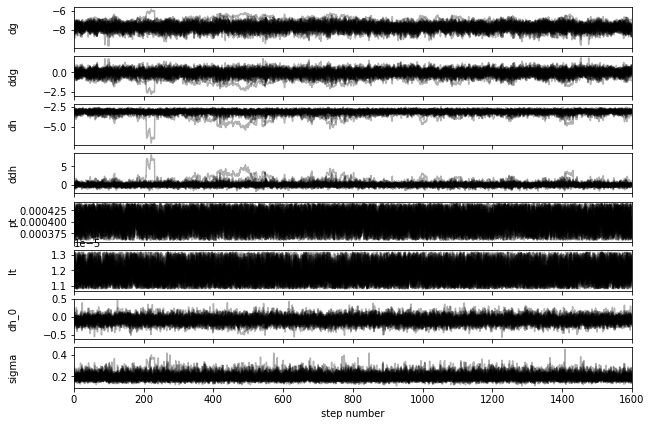

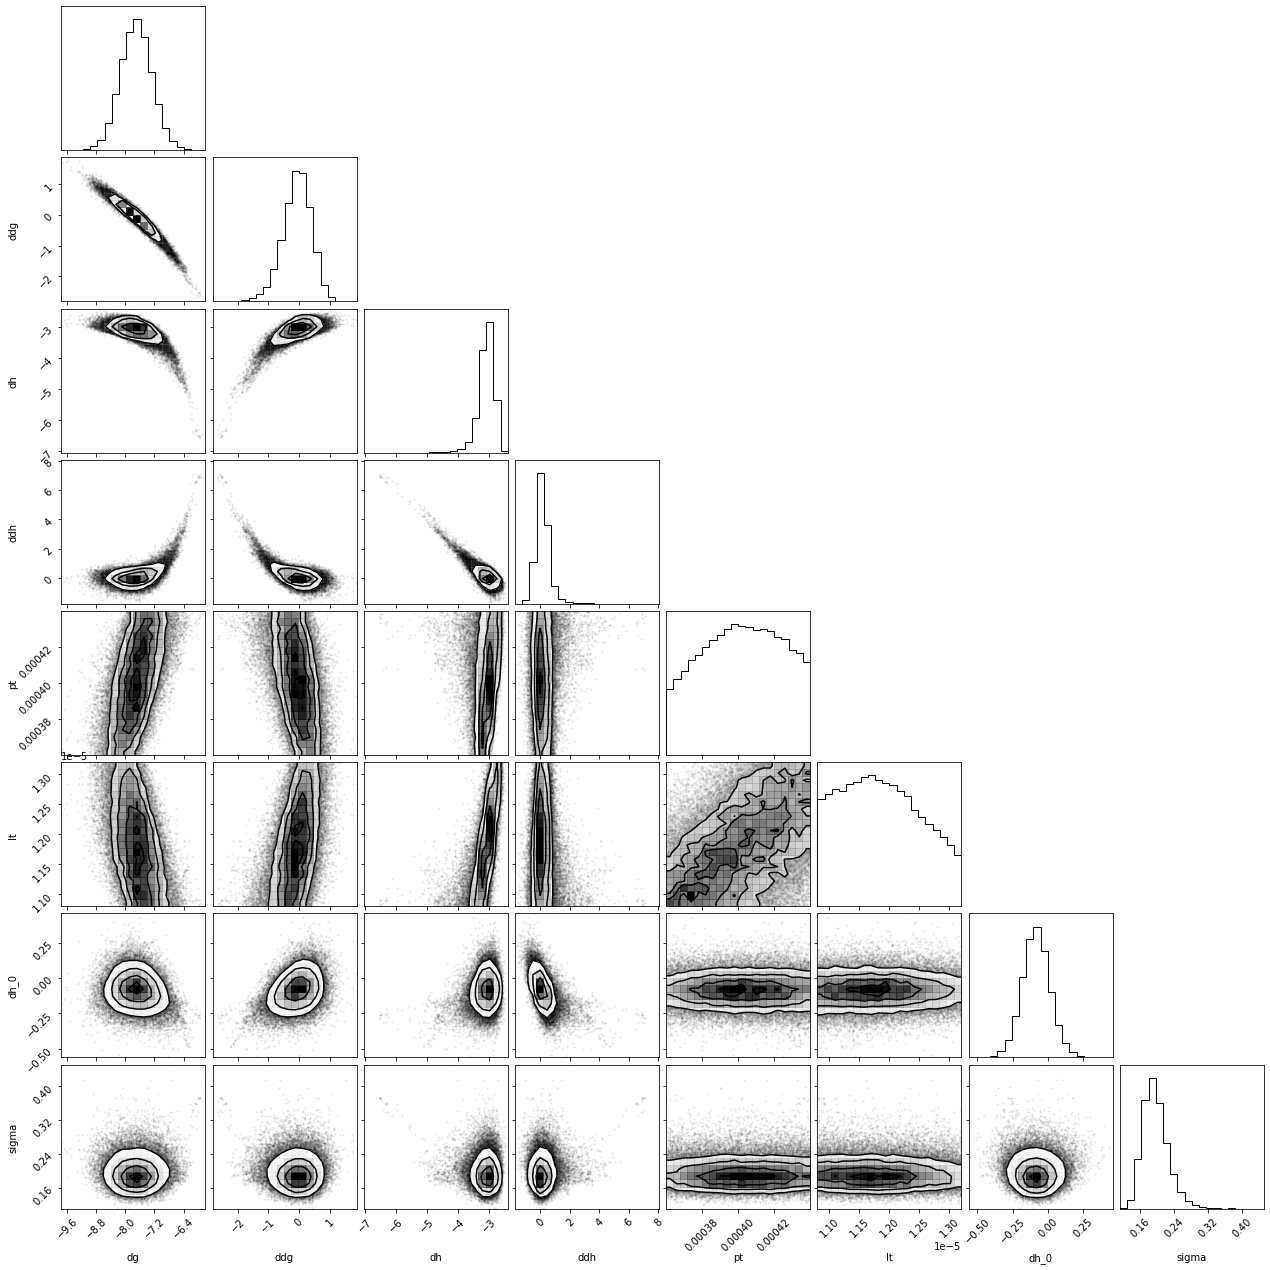

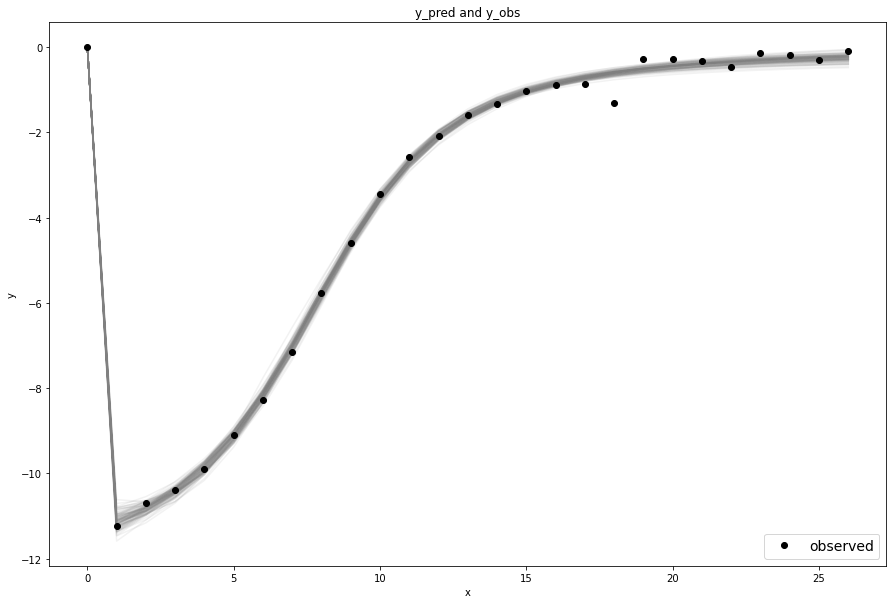

In [25]:
### 7 parameter itc model analysis
import matplotlib.pyplot as plt
import corner 

#retrieve saved data (not always needed, comment out when unused)
import emcee
import numpy as np
import itcfunctions as itc
#filename = 'ic_ndh_iso1_run1'
sampler = emcee.backends.HDFBackend(f'save_{filename}.dat')
samples = sampler.get_chain(thin=50,discard=20000)
burn_in = int(len(samples*0.2))
n_dim = len(samples[0][1])




# mcmc trajectory (before burn in)
fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
labels = ["dg", "ddg", "dh", "ddh", "pt", "lt", "dh_0", "sigma"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.savefig(f'{filename}_traces.png')
# autocorrelation time (for measuring sampling performance)
# note: this can give an error if the run length isn't 50x the autocorrelation
#tau = sampler.get_autocorr_time()
#print(tau)


# corner plot (1d and 2d histograms)

flat_samples = sampler.get_chain(discard=20000, thin=50, flat=True)
n_v_list = [122,122,122,122,122,122,122,122]
#theta_true = [-7,-1,-10,-1.5, 0.0005, 1.7e-05, 0.2]
bounds = [(-9,-5),(-4,4),(-20,0),(-10,10),(0.00033-0.00033*0.1,0.00033+0.00033*0.1), 
          ((1.165e-05)-(1.165e-05)*0.1, (1.165e-05)+(1.165e-05)*0.01),(-20,20),(0.001,1)]
auto = True

if not auto:
    fig = corner.corner(
        flat_samples, labels=labels,
        bins=n_v_list, range = bounds, plot_contours=True,
        plot_density=True,
    )
else:
    fig = corner.corner(
        flat_samples, labels=labels,
    )
plt.savefig(f'{filename}_2dcorr.png')


# plot y_predicted and y_observed
inds = np.random.randint(len(flat_samples), size=100)
plt.figure(figsize = (15, 10))
for ind in inds:
    sample = flat_samples[ind]
    y_pred_i = itc.get_dq_list(sample[0],sample[1],sample[2],sample[3],
                                sample[4], sample[5], sample[6],extra_parameters[0])
    plt.plot(y_pred_i, alpha=0.1, color='grey')
plt.title('y_pred and y_obs')
plt.ylabel('y')
plt.xlabel('x')

plt.plot(y_obs, ls='None', color='black', marker='o',label="observed")
plt.legend(fontsize=14)

plt.savefig(f'{filename}_example_plots.png')

In [10]:
plt.savefig('example_poor_output_traces.png')

<Figure size 432x288 with 0 Axes>

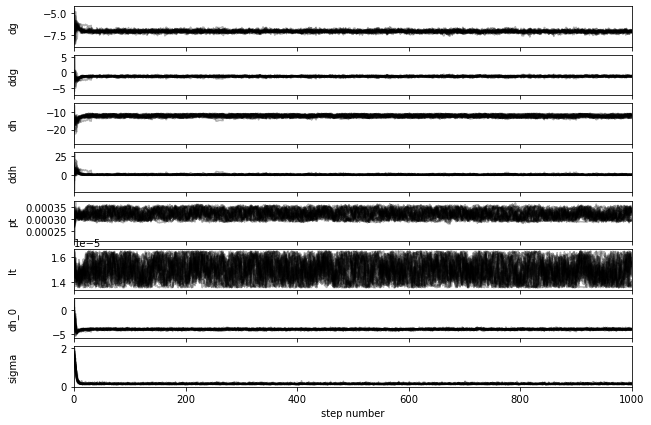

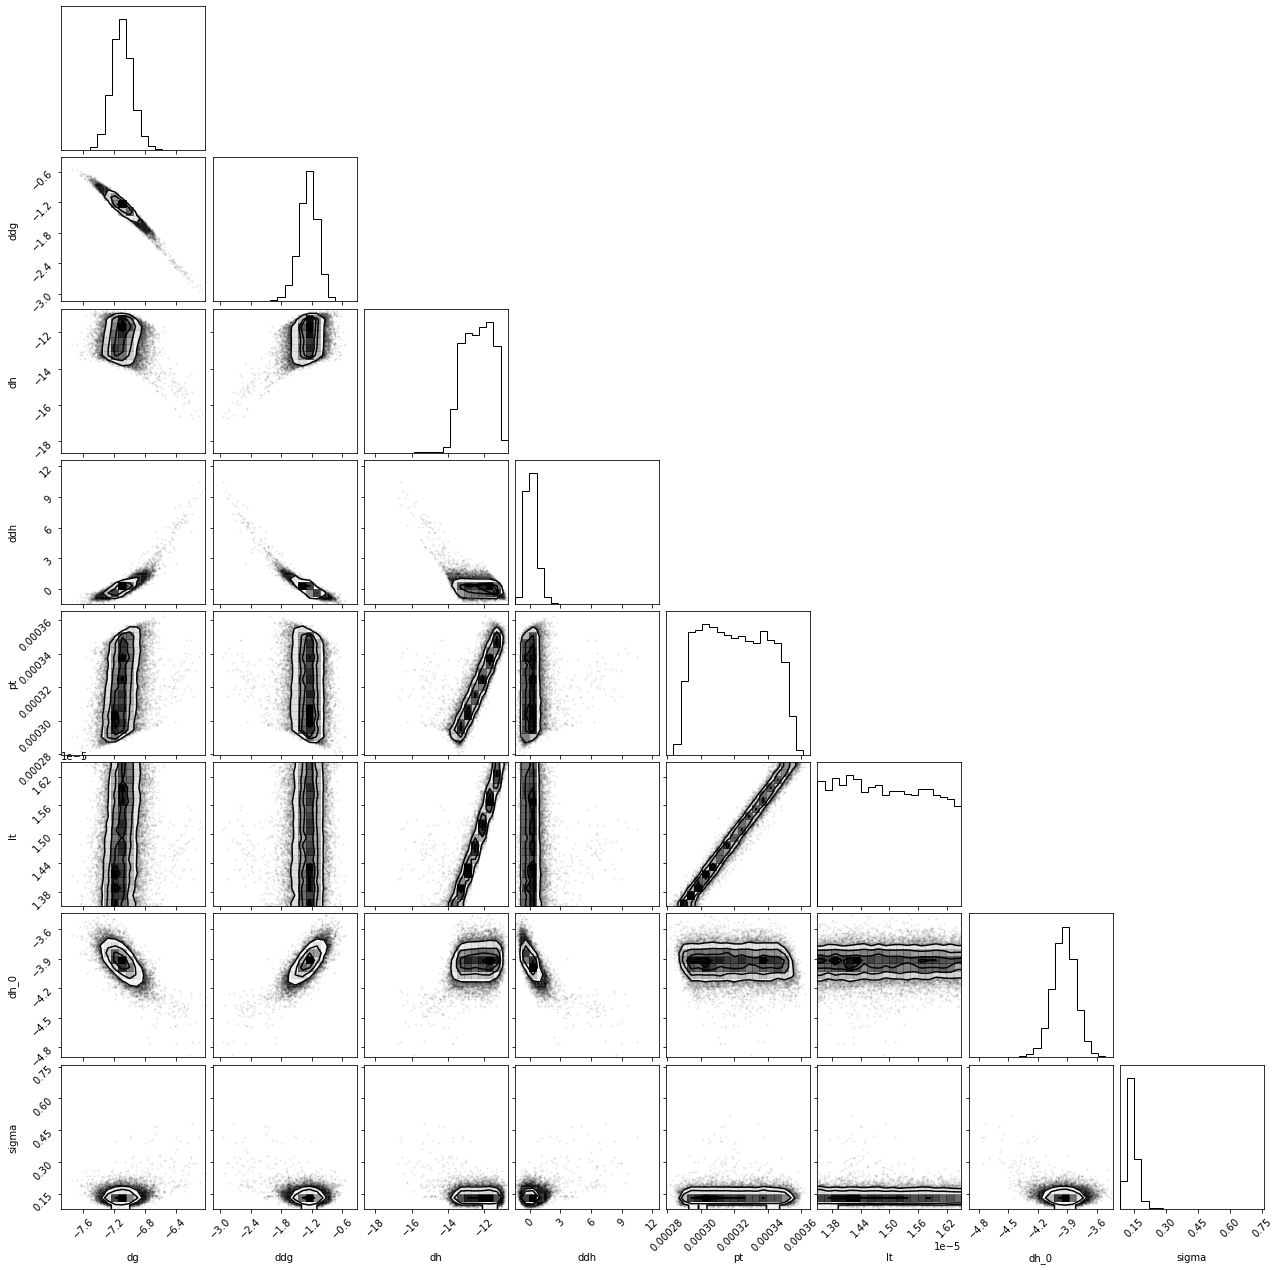

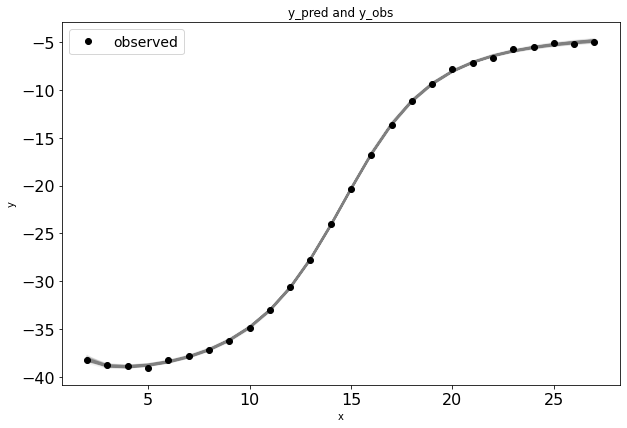

In [6]:
### 7 parameter itc model analysis
import matplotlib.pyplot as plt
import matplotlib as mpl
import corner 

#retrieve saved data (not always needed, comment out when unused)
import emcee
import numpy as np
import itcfunctions as itc
#filename = 'spag5_final_run3'

sampler = emcee.backends.HDFBackend(f'save_{filename}.dat')
samples = sampler.get_chain(thin=50)
burn_in = int(len(samples)*0.3)
n_dim = len(samples[0][1])




# mcmc trajectory (before burn in)
fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
labels = ["dg", "ddg", "dh", "ddh", "pt", "lt", "dh_0", "sigma"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.savefig(f'{filename}_traces.png')
# autocorrelation time (for measuring sampling performance)
# note: this can give an error if the run length isn't 50x the autocorrelation
#tau = sampler.get_autocorr_time()
#print(tau)


# corner plot (1d and 2d histograms)

flat_samples = sampler.get_chain(discard=burn_in, thin=50, flat=True)
n_v_list = [122,122,122,122,122,122,122]
theta_true = [-7,-1,-10,-1.5, 0.0005, 1.7e-05, 0.2]
bounds = [(-9,-5),(-4,4),(-20,0),(-10,10),(0.0005-0.0005*0.05,0.0005+0.0005*0.05), ((1.7e-05)-(1.7e-05)*0.05, (1.7e-05)+(1.7e-05)*0.05), (0.001,0.5)]
auto = True

if not auto:
    fig = corner.corner(
        flat_samples, labels=labels, truths=theta_true,
        bins=n_v_list, range = bounds, plot_contours=True,
        plot_density=True,
    )
else:
    fig = corner.corner(
        flat_samples, labels=labels,
    )
plt.savefig(f'{filename}_2dcorr.png')


mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 

# plot y_predicted and y_observed
inds = np.random.randint(len(flat_samples), size=100)
plt.figure(figsize = (10, 6.67))
for ind in inds:
    sample = flat_samples[ind]
    y_pred_i = itc.get_dq_list(sample[0],sample[1],sample[2],sample[3],
                                sample[4], sample[5], sample[6],extra_parameters[0])
    plt.plot(range(2,len(y_pred_i)+1),y_pred_i[1:], alpha=0.1, color='grey')
plt.title('y_pred and y_obs')
plt.ylabel('y')
plt.xlabel('x')

plt.plot(range(2,len(y_obs)+1),y_obs[1:], ls='None', color='black', marker='o',label="observed")
plt.legend(fontsize=14)

plt.savefig(f'{filename}_example_plots.pdf')

-7.359004065537244 -6.812126086945089
-1.6959265406083777 -0.9329636543161641
-13.700095791511743 -11.141828974108686
-0.7237806892134102 1.47987029971602
0.00029053366652853933 0.00035245545084522725
1.3569805101678965e-05 1.6412570843019597e-05
-4.183263629444485 -3.702777217904481
0.10245854917048305 0.1925728377120529


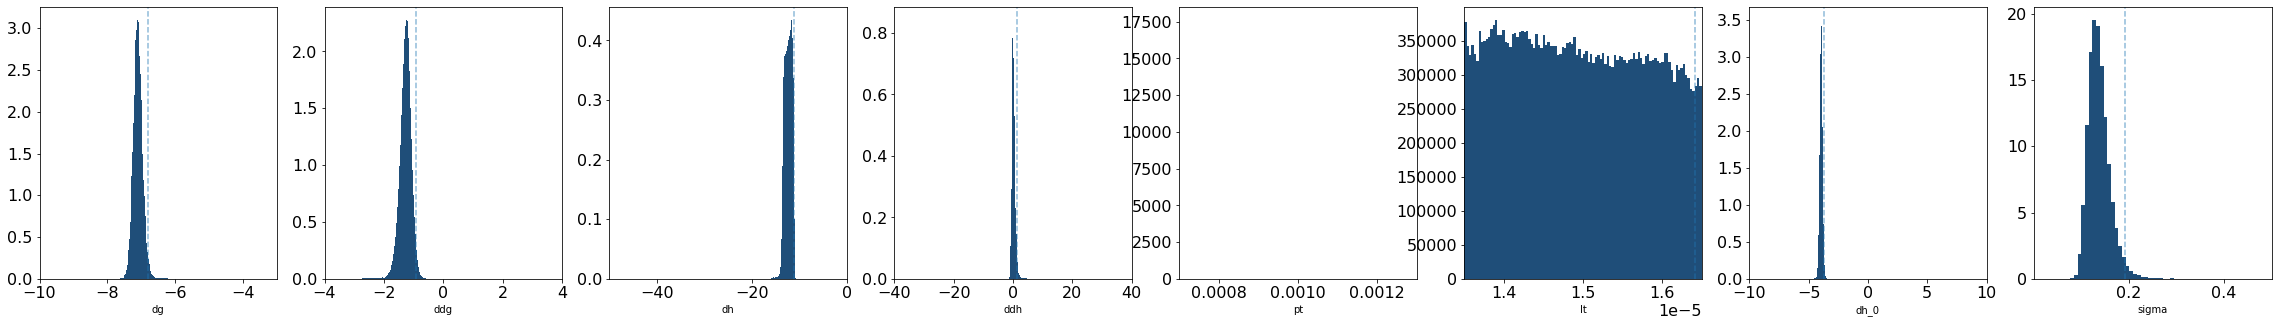

In [10]:
import matplotlib as mpl
fig,axs = plt.subplots(1,8,figsize=(40,5))
#sampler = emcee.backends.HDFBackend(f'save_run1_wide_enthalpypriors.dat')
flat_samples = sampler.get_chain(discard=burn_in, thin=1, flat=True)
limits = [(-10,-3),(-4,4),(-50,0),(-40,40),(0.001-0.001*0.3,0.001+0.001*0.3), ((1.5e-05)-(1.5e-05)*0.1, (1.5e-05)+(1.5e-05)*0.1), (-10,10),(0.001,0.5)]

mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 

for j in range(n_dim):
    ax = axs[j]
        
     ##get values and CI
    values = [flat_samples[k][j] for k in range(len(flat_samples))]
    values.sort()
    CI_interval = int(len(values)*0.025)
    CI_low = values[CI_interval]
    ax.axvline(CI_low,alpha=0.,ls='--')
    CI_high = values[-CI_interval]
    ax.axvline(CI_high,alpha=0.5,ls='--')
    print(CI_low,CI_high)
    
    
    #plot hist
    ax.hist(values,
            bins=100,alpha=1,density=True,color='#1f4e79',histtype='stepfilled')
    ax.set_xlim(limits[j])
    ax.set_xlabel(labels[j])


plt.savefig('example.pdf')

/home/bb/estellea/.conda/envs/bayesitc/lib/python3.8/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


3.9784150849250253 6.653838922164714
-3.00729450889589 -0.23241742283942646


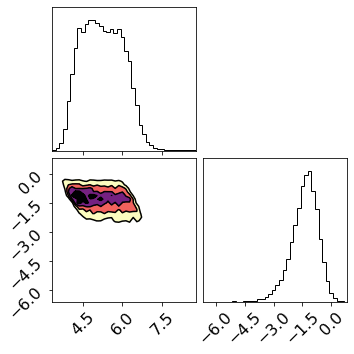

In [11]:
##little thing for getting TdS and also TddS

flat_samples = sampler.get_chain(discard=10000, thin=50, flat=True)
cut_list = []
cmap_darklight = plt.cm.get_cmap('magma')
cmap = cmap_darklight.reversed()


for sample in flat_samples:
    
    tds = (sample[0] - sample[2])
    tds_2 = ((sample[0]+sample[1]) - (sample[2]+sample[3]))
    tdds = tds_2 - tds
    cut_list.append([tds,tdds])
cut_samples = np.array(cut_list)
fig = corner.corner(cut_samples,truth_color='r',bins=40,labels=None,plot_datapoints=False,fill_contours=True,
                    contourf_kwargs={'alpha':1,'cmap':None,'colors':['white',cmap(0),cmap(0.33),cmap(0.66),cmap(0.999)]})

plt.savefig('subcut_thermodynamics_just_tds.pdf')


for j in range(len(cut_list[0])):
        
     ##get values and CI
    values = [cut_list[k][j] for k in range(len(cut_list))]
    values.sort()
    CI_interval = int(len(values)*0.025)
    CI_low = values[CI_interval]
    CI_high = values[-CI_interval]
    print(CI_low,CI_high)

/home/bb/estellea/.conda/envs/bayesitc/lib/python3.8/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)
/home/bb/estellea/.conda/envs/bayesitc/lib/python3.8/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)
/home/bb/estellea/.conda/envs/bayesitc/lib/python3.8/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengt

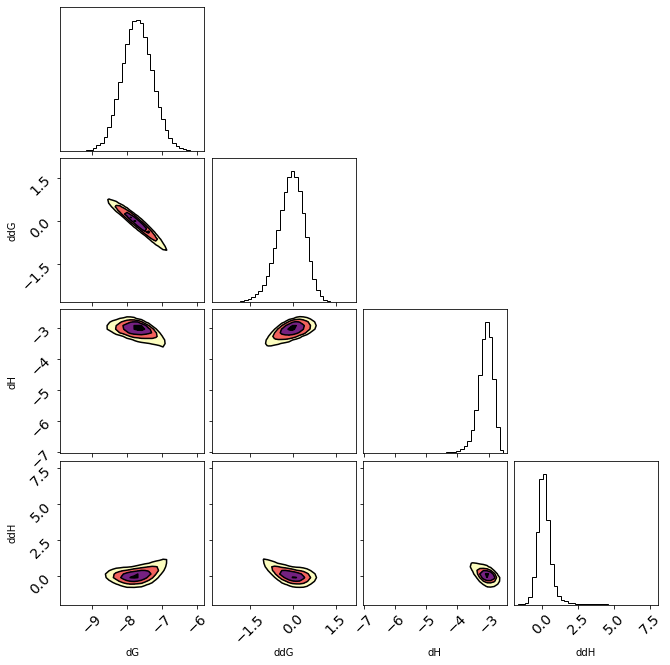

In [27]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
cut_list = []
import matplotlib as mpl

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

cmap_darklight = plt.cm.get_cmap('magma')
cmap = cmap_darklight.reversed()

for sample in flat_samples:
    cut_list.append([sample[0],sample[1],sample[2],sample[3]])
cut_samples = np.array(cut_list)
fig = corner.corner(cut_samples,truth_color='r',bins=40,labels=['dG','ddG','dH','ddH'],plot_datapoints=False,fill_contours=True,
                    contourf_kwargs={'alpha':1,'cmap':None,'colors':['white',cmap(0),cmap(0.33),cmap(0.66),cmap(0.999)]})

plt.savefig('subcut_thermodynamics.pdf')

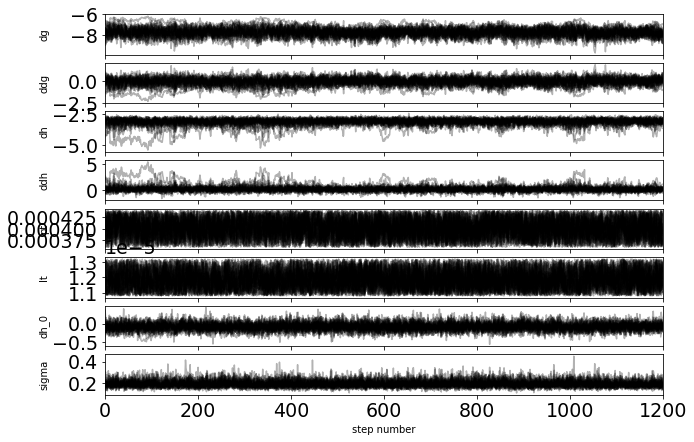

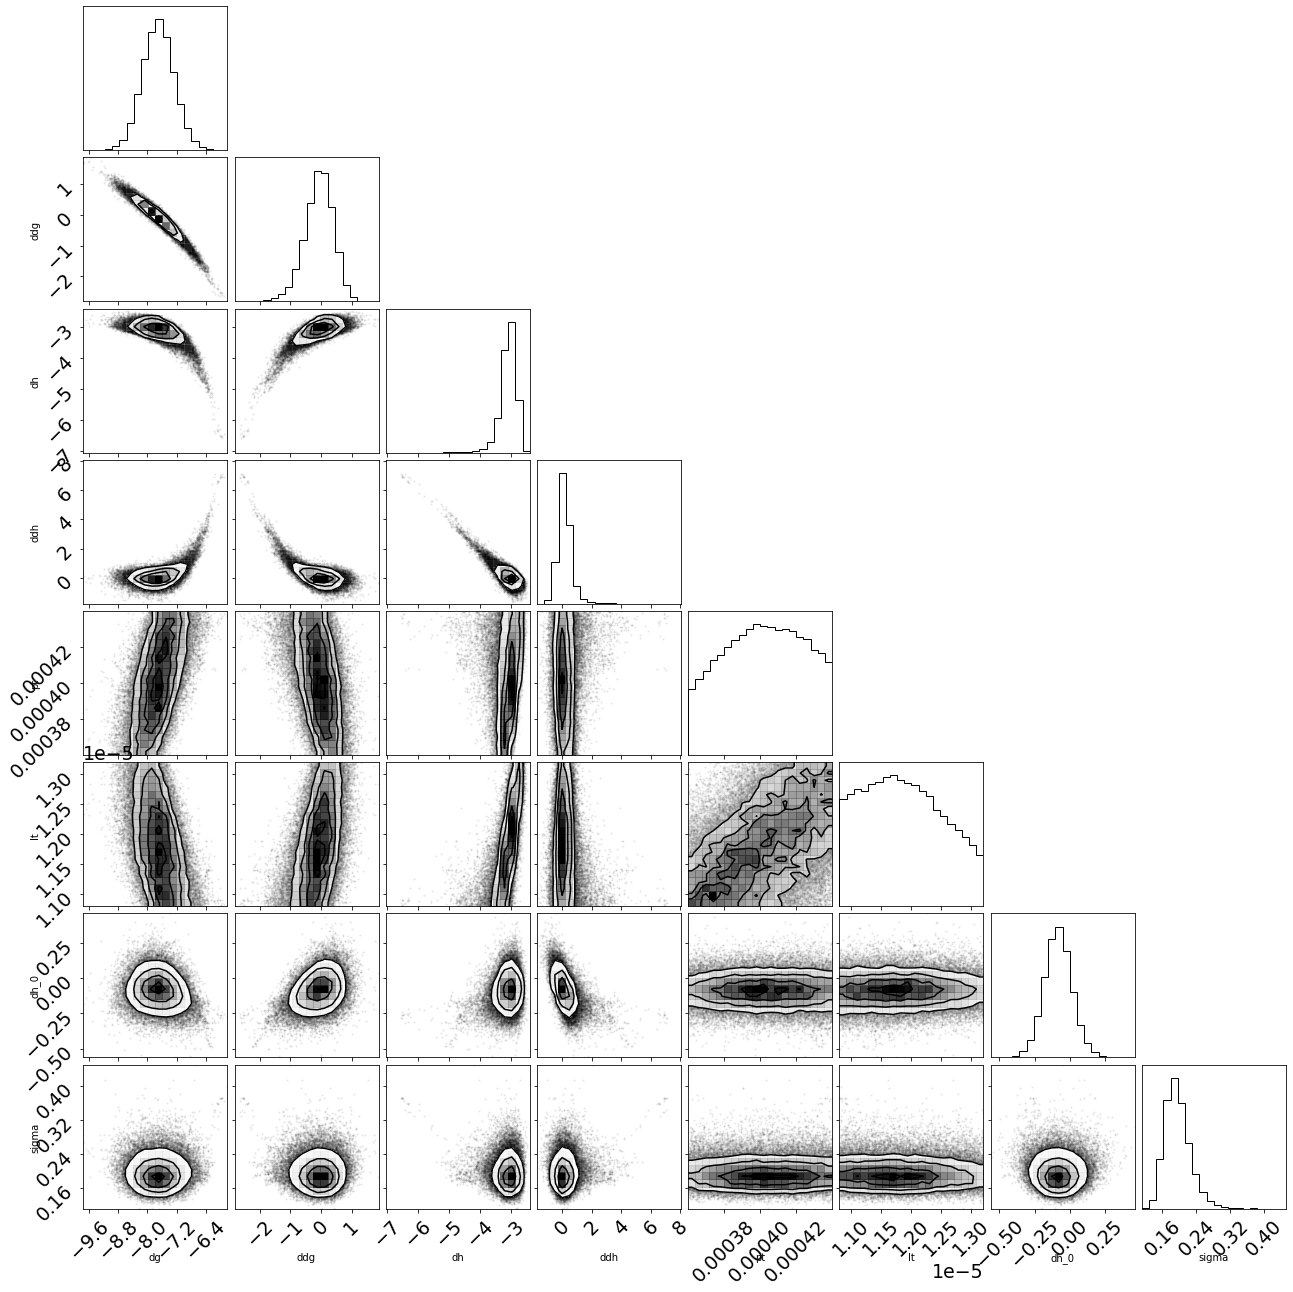

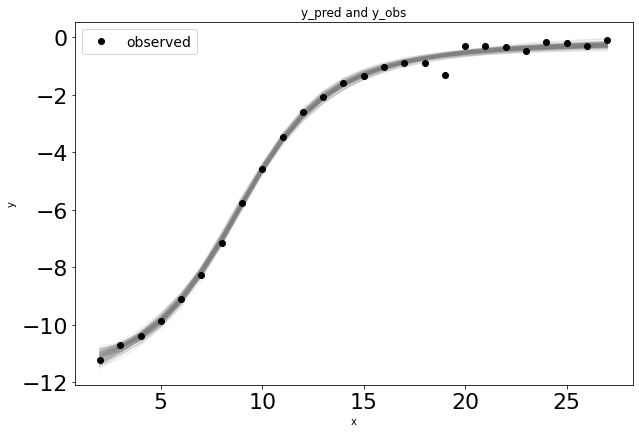

In [36]:
### 7 parameter itc model analysis
import matplotlib.pyplot as plt
import matplotlib as mpl
import corner 

#retrieve saved data (not always needed, comment out when unused)
import emcee
import numpy as np
import itcfunctions as itc
filename = 'ic_ndh_iso1_run1'

sampler = emcee.backends.HDFBackend(f'save_{filename}.dat')
samples = sampler.get_chain(thin=50,discard=40000)
burn_in = int(len(samples)*0.4)
n_dim = len(samples[0][1])




# mcmc trajectory (before burn in)
fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
labels = ["dg", "ddg", "dh", "ddh", "pt", "lt", "dh_0", "sigma"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.savefig(f'{filename}_traces.png')
# autocorrelation time (for measuring sampling performance)
# note: this can give an error if the run length isn't 50x the autocorrelation
#tau = sampler.get_autocorr_time()
#print(tau)


# corner plot (1d and 2d histograms)

flat_samples = sampler.get_chain(discard=20000, thin=50, flat=True)
n_v_list = [122,122,122,122,122,122,122]
theta_true = [-7,-1,-10,-1.5, 0.0005, 1.7e-05, 0.2]
bounds = [(-9,-5),(-4,4),(-20,0),(-10,10),(0.0005-0.0005*0.05,0.0005+0.0005*0.05), ((1.7e-05)-(1.7e-05)*0.05, (1.7e-05)+(1.7e-05)*0.05), (0.001,0.5)]
auto = True

if not auto:
    fig = corner.corner(
        flat_samples, labels=labels, truths=theta_true,
        bins=n_v_list, range = bounds, plot_contours=True,
        plot_density=True,
    )
else:
    fig = corner.corner(
        flat_samples, labels=labels,
    )
plt.savefig(f'{filename}_2dcorr.png')


mpl.rc('xtick', labelsize=22) 
mpl.rc('ytick', labelsize=22) 

# plot y_predicted and y_observed
inds = np.random.randint(len(flat_samples), size=100)
plt.figure(figsize = (10, 6.67))
for ind in inds:
    sample = flat_samples[ind]
    y_pred_i = itc.get_dq_list(sample[0],sample[1],sample[2],sample[3],
                                sample[4], sample[5], sample[6],extra_parameters[0])
    plt.plot(range(2,len(y_pred_i)+1),y_pred_i[1:], alpha=0.1, color='grey')
plt.title('y_pred and y_obs')
plt.ylabel('y')
plt.xlabel('x')

plt.plot(range(2,len(y_obs)+1),y_obs[1:], ls='None', color='black', marker='o',label="observed")
plt.legend(fontsize=14)

plt.savefig(f'{filename}_example_plots.pdf')